# Pytorch - FasterRCNN Inference

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from utils import WheatDataset, format_prediction_string, predict_bbox, load_data

# Set environment
ENV = 'gcloud' 

# Set data directory
if ENV == 'gcloud':
    DIR_INPUT = 'data'
elif ENV == 'kaggle':
    DIR_INPUT = '../input/global-wheat-detection'
else:
    print("Error: invalid environment specified")
    
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

DIR_WEIGHTS = 'imgaug-cutmix'

# WEIGHTS_FILE = f'{DIR_WEIGHTS}/fasterrcnn_resnet50_fpn.pth'
WEIGHTS_FILE = f'{DIR_WEIGHTS}/best_weights.pth'

In [14]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df.shape

(10, 2)

# Init model

Load in the weights from our weights file

In [15]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

# Construct dataloader and make preds

In [27]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [28]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [29]:
# Load raw data
train_df, valid_df, test_df = load_data(DIR_INPUT, load = True)

valid_dataset = WheatDataset(dataframe = valid_df, 
                             image_dir = DIR_TRAIN,
                             augment = False)

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

In [30]:
# Get data loaders
def collate_fn(batch): # collates a batch
    return tuple(zip(*batch))

# Get data loader for training loop
BATCH_VAL = 4
BATCH_TE = 4

valid_data_loader = DataLoader(valid_dataset, 
                               batch_size=BATCH_VAL,
                               shuffle=True,
                               num_workers=0,
                               collate_fn=collate_fn)

test_data_loader = DataLoader(test_dataset, 
                               batch_size=BATCH_TE,
                               shuffle=True,
                               num_workers=0,
                               collate_fn=collate_fn)

# Get image and boxes for image_id in test set

In [32]:
# Predict labels for new images
detection_threshold = 0.5
is_submission=False
results = []
images_dict = {}

for images, image_ids in test_data_loader:
    # save ids to a dict for plotting
    for image, image_id in zip(images, image_ids):
        images_dict[image_id] = image
        
    images = list(image.to(device) for image in images)
    results += predict_bbox(images, image_ids, model, detection_threshold, is_submission)    

if is_submission:
    new_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
else:
    new_df = pd.DataFrame(results, columns=['image_id','x1','y1','x2','y2'])

new_df

,image_id,x1,y1,x2,y2
0,f5a1f0358,542,401,631,504
1,f5a1f0358,144,243,235,338
2,f5a1f0358,252,658,358,746
3,f5a1f0358,685,199,805,298
4,f5a1f0358,131,742,306,882
...,...,...,...,...,...
279,aac893a91,887,927,951,1016
280,aac893a91,597,613,684,727
281,aac893a91,331,662,417,774
282,aac893a91,825,791,898,889


In [33]:
image_id = '53f253011'          

image = images_dict[image_id].permute(1,2,0).cpu().numpy()
boxes = new_df[new_df['image_id'] == image_id][['x1', 'y1', 'x2', 'y2']].to_numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


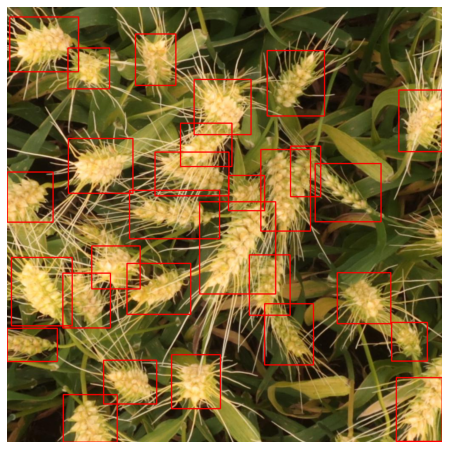

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(image,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(image)

In [11]:
# test_df.to_csv('submission.csv', index=False)

# Inference on valid set

In [35]:
detection_threshold = 0.5
images, d = next(iter(valid_data_loader))
images = list(image.to(device) for image in images)

outputs = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


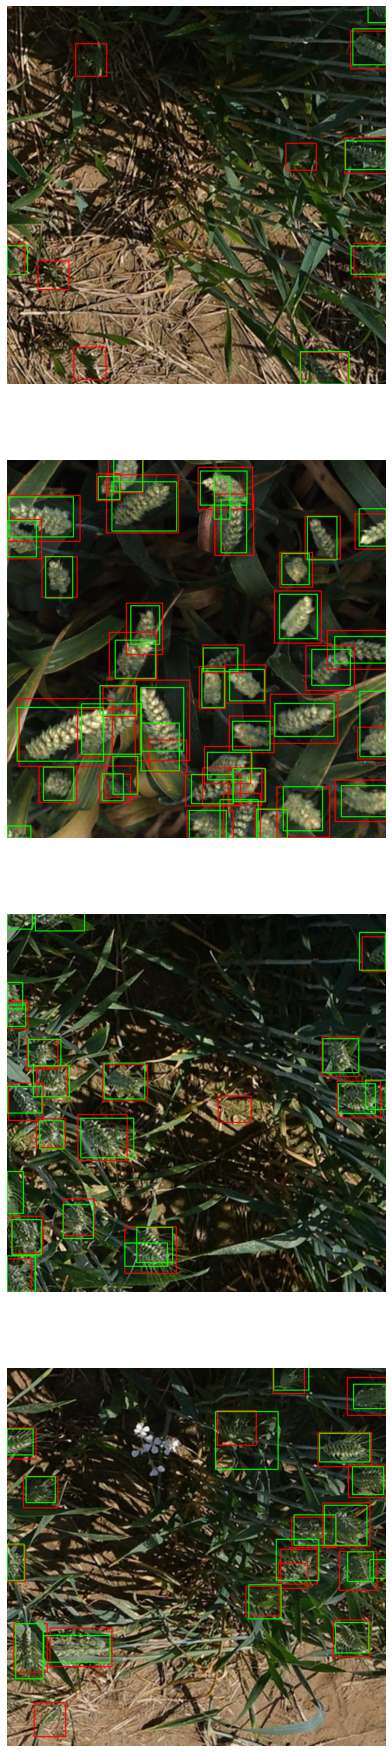

In [36]:
fig, ax = plt.subplots(BATCH_VAL, 1, figsize=(64, 32))

for i, image in enumerate(images):
    # get real boxes
    boxes_real = d[i]['boxes']
    # get predicted boxes
    boxes = outputs[i]['boxes'].data.cpu().numpy()
    scores = outputs[i]['scores'].data.cpu().numpy()
    
    # Cut off at probability score threshold
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    scores = scores[scores >= detection_threshold]
    reshaped_image = image.permute(1,2,0).cpu().numpy()
    
    for box in boxes:
        cv2.rectangle(reshaped_image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)

    for box in boxes_real:
        cv2.rectangle(reshaped_image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)

    ax[i].set_axis_off()
    ax[i].imshow(reshaped_image)

# Precision

Calculate the precision over the images in the valid set

In [55]:
# model.load_state_dict(torch.load('fasterrcnn_custom_test_ep18_loss0.598.pth'))

<All keys matched successfully>

In [37]:
from metrics import *

In [38]:
validation_image_precisions = []
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

for images, d in valid_data_loader:
    # convert image to device to run through model
    images = list(image.to(device) for image in images)
    outputs = model(images)
    for i, image in enumerate(images):
        # convert back to cpu to calculate
        preds = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()

        # Cut off at probability score threshold
        preds = preds[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        gt_boxes = d[i]['boxes'].cpu().numpy()

        preds_sorted_idx = np.argsort(scores)[::-1]
        preds_sorted = preds[preds_sorted_idx]

        for idx, image in enumerate(images):
            image_precision = calculate_image_precision(preds_sorted,
                                                        gt_boxes,
                                                        thresholds=iou_thresholds,
                                                        form='coco')

            validation_image_precisions.append(image_precision)

In [39]:
print("Validation IOU: {0:.4f}".format(np.mean(validation_image_precisions)))

Validation IOU: 0.7885


# Augment 10 epoch

In [54]:
print("Validation IOU: {0:.4f}".format(np.mean(validation_image_precisions)))

Validation IOU: 0.8323


# Augment 18 epoch

In [58]:
print("Validation IOU: {0:.4f}".format(np.mean(validation_image_precisions)))

Validation IOU: 0.8328


# fasterrcnn_resnet50_fpn2nd.pth

In [49]:
print("Validation IOU: {0:.4f}".format(np.mean(validation_image_precisions)))

Validation IOU: 0.8133


# Find the loss on val set

In [15]:
# model.load_state_dict(torch.load('fasterrcnn_custom_test_ep10_loss0.598.pth'))

<All keys matched successfully>

In [16]:
from utils import Averager

model.train()
val_loss_hist = Averager()

# Validation Step
for images, targets in valid_data_loader:

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    val_loss_dict = model(images, targets)

    val_losses = sum(loss for loss in val_loss_dict.values())
    val_loss_value = val_losses.item()

    val_loss_hist.send(val_loss_value)

# Augment 18 epoch

In [17]:
val_loss_hist.value

0.6024518091521577

# Augment 10 epoch

In [14]:
val_loss_hist.value

0.5961840993273044

# fasterrcnn_resnet50_fpn

In [19]:
val_loss_hist.value

0.684623579957528

# fasterrcnn_resnet50_fpn2nd

In [17]:
val_loss_hist.value

0.5644156561640208

# "best_weights" 2 epochs

In [12]:
val_loss_hist.value

0.6216460766192682